In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from model import *

In [3]:
# Load dataset
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
dataset0to4 = [i for i in MNIST_TEST if i[1] in [0, 1, 2, 3, 4]]
dataset5to9 = [(i[0], i[1]-5) for i in MNIST_TEST if i[1] in [5, 6, 7, 8, 9]]
dataloader0to4 = DataLoader(dataset0to4, shuffle=True, batch_size=256)
dataloader5to9 = DataLoader(dataset5to9, shuffle=True, batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training and Evaluation Code

In [4]:
SEED = 42

def train(model, dataloader, optimizer,
          criterion=None,
          num_epochs=5,
          head_index=0,
         ):
    model.train()
    if not criterion:
        criterion = torch.nn.CrossEntropyLoss()
    losses = []
    for epoch in tqdm(range(num_epochs), leave=True):
        train_loss = 0.0
        for batch in tqdm(dataloader, leave=False): 
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)[head_index]
            loss = criterion(y_hat, y)

            loss_val = loss.detach().cpu().item()
            train_loss += loss_val / len(dataloader)
            losses.append(loss_val)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

    plt.plot(losses)
    plt.show()

In [5]:
def eval_model(model, dataloader,
               head_index=0,
              ):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[head_index]
            predictions = torch.argmax(outputs, dim=-1)
            total += labels.shape[0]
            correct += (predictions == labels).sum().item()
        accuracy = correct / total

    print(f"{accuracy*100:.2f}%")

# Base Model

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.31


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.71


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.38


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.23


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.16


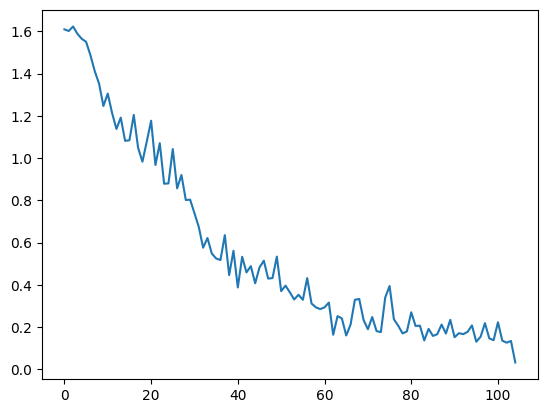

In [6]:
torch.manual_seed(SEED)
base_model = TheModel(
    mlp_head_sizes=[512, 5],
)
base_model.to(device)

optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

train(base_model, dataloader0to4, optimizer)

In [7]:
eval_model(base_model, dataloader0to4, head_index=0)

95.15%


# Full Finetuning

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 0.88


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.44


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.36


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.30


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.25


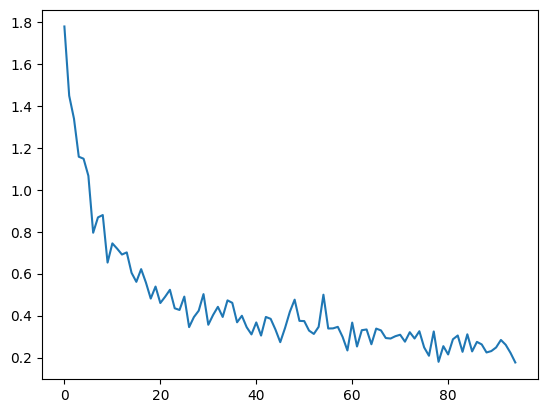

In [8]:
torch.manual_seed(SEED)
full_finetune_model = copy.deepcopy(base_model)
full_finetune_model.add_head(
    mlp_head_sizes=[512, 5],
    memory_tokens=0,
)
optimizer = torch.optim.Adam(full_finetune_model.parameters(), lr=0.001)

train(full_finetune_model, dataloader5to9, optimizer, head_index=1)

In [9]:
eval_model(full_finetune_model, dataloader0to4, head_index=0)
eval_model(full_finetune_model, dataloader5to9, head_index=1)

56.37%
93.33%


# Head-and-class-only Finetuning

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.05


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.84


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.78


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.74


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.71


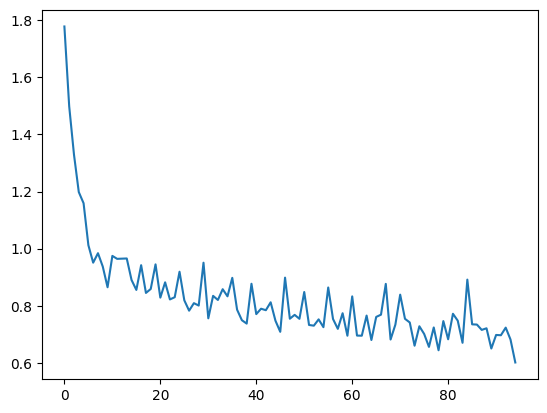

In [10]:
torch.manual_seed(SEED)
head_finetune_model = copy.deepcopy(base_model)
parameters = head_finetune_model.add_head(
    mlp_head_sizes=[512, 5],
    memory_tokens=0,
)
optimizer = torch.optim.Adam(parameters, lr=0.001)

train(head_finetune_model, dataloader5to9, optimizer, head_index=1)

In [11]:
eval_model(head_finetune_model, dataloader0to4, head_index=0)
eval_model(head_finetune_model, dataloader5to9, head_index=1)

94.96%
74.84%


# Memory

Add learnable memory, fine tune head + memory.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.07


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.84


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.78


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.75


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.71


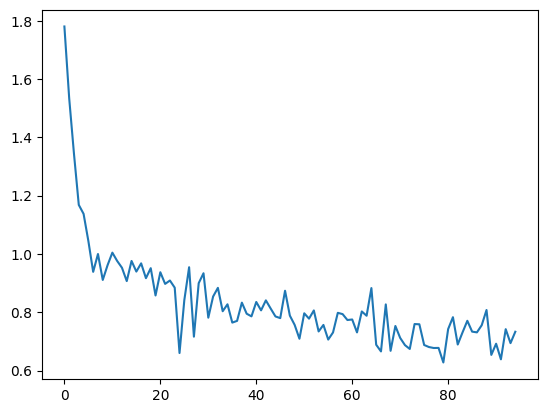

In [12]:
torch.manual_seed(SEED)
memory_finetune_model = copy.deepcopy(base_model)
parameters = memory_finetune_model.add_head(
    mlp_head_sizes=[512, 5],
    memory_tokens=2,
)
optimizer = torch.optim.Adam(parameters, lr=0.001)

train(memory_finetune_model, dataloader5to9, optimizer, head_index=1)

In [13]:
eval_model(memory_finetune_model, dataloader0to4, head_index=0)
eval_model(memory_finetune_model, dataloader5to9, head_index=1)

95.15%
74.51%


In [14]:
memory_finetune_model.transformers[0].attention.mask

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        